# Final Project-CNN classifier for cells tissue - healty/cancer
# Name: Ran Ben Melech


## installing needed api's for the model
(the model will use tfds dataset for the project)

In [2]:
pip install tensorflow-datasets

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## importing needed libraries

In [3]:
import tensorflow as tf
#model imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Conv2D,MaxPool2D,Dropout,Activation,BatchNormalization,GlobalAveragePooling2D
from tensorflow import keras
from keras.optimizers import Adam

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
from keras import backend as K
import tensorflow_datasets as tfds
print(tf.__version__)

2.3.0


## loading the patch camelyon dataset from tfds library and write it to virtual drive in colab
loading takes 10-20 minutes.

In [4]:
(train,validation,test), info  = tfds.load('patch_camelyon', split=['train','validation','test'], as_supervised=True,with_info=True)
info


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZ9560R/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZ9560R/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteZ9560R/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018_

## transform dataset to batches so google colab could run it 
(without batches colab crashes from ram overuse)

In [5]:
#prefetch is helping model running speed by loading next 3 batches
batch_size=128
train = train.cache().batch(batch_size).prefetch(buffer_size=2)
validation = validation.cache().batch(batch_size).prefetch(buffer_size=2)
test = test.cache().batch(batch_size).prefetch(buffer_size=2)
print (train)


<PrefetchDataset shapes: ((None, 96, 96, 3), (None,)), types: (tf.uint8, tf.int64)>


## example plotting

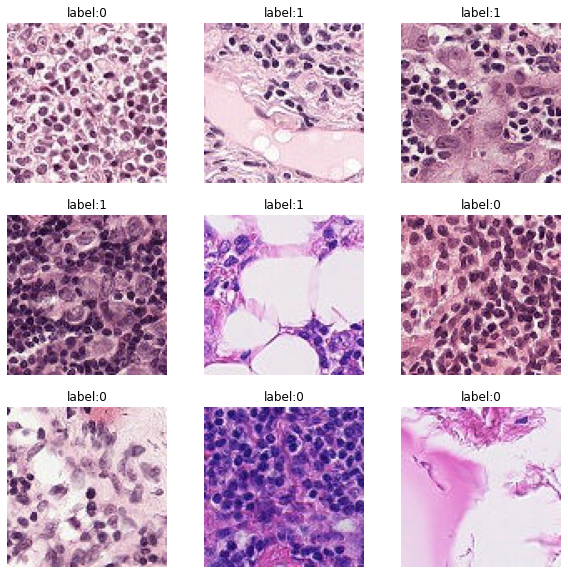

In [6]:

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i])
    plt.title('label:'+str(int(label[i])))
    plt.axis("off")

## data augmentation with keras preprocessing
(data augmentation for DatasetV1Adapter object requires special way to preprocess)

In [7]:
data_augmentation = keras.Sequential(
    [
        
        keras.layers.experimental.preprocessing.RandomFlip(),
        keras.layers.experimental.preprocessing.RandomRotation(0.9),
        keras.layers.experimental.preprocessing.RandomZoom(0.2),
        
       
    ]
)


## data augmentation plotting

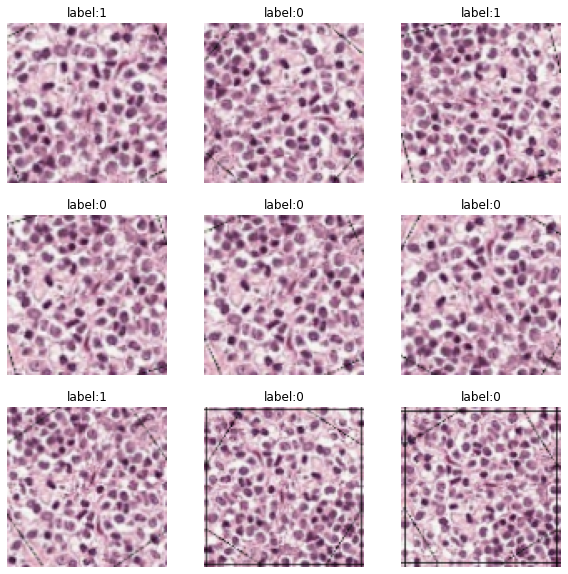

In [8]:
for images, labels in train.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title('label:'+str(int(label[i])))
        plt.axis("off")

## build the model using ResNet50 as base model

In [9]:
base_model = keras.applications.ResNet50(weights='imagenet', 
    # Load weights pre-trained on ImageNet.
    input_shape=(48, 48, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

inputs = keras.Input(shape=(96,96,3),batch_size=batch_size)
# Apply random data augmentation
x = data_augmentation(inputs)
#cropping the images
x=keras.layers.experimental.preprocessing.CenterCrop(48,48)(x)
# Rescale images to [0, 1]
Rescale = keras.layers.experimental.preprocessing.Rescaling(1./255)
x = Rescale(x)
#freeze layers in base model
for layer in base_model.layers[:-13]:
    layer.trainable = False

x = base_model(x)
x=keras.layers.Flatten()(x)
x=keras.layers.Dense(256,use_bias=False,activation='relu')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Dropout(0.4)(x)
outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 96, 96, 3)]        0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
center_crop (CenterCrop)     (128, 48, 48, 3)          0         
_________________________________________________________________
rescaling (Rescaling)        (128, 48, 48, 3)          0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (128, 8192)               0         
_______________________________________________________

## compile and train the model

In [10]:
model.compile(
    optimizer=keras.optimizers.Nadam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 30
history=model.fit(train, epochs=epochs ,validation_data=validation)

Epoch 1/30
2048/2048 [==============================] - 218s 106ms/step - loss: 0.6360 - binary_accuracy: 0.7001 - val_loss: 0.6417 - val_binary_accuracy: 0.6879
Epoch 2/30
2048/2048 [==============================] - 73s 36ms/step - loss: 0.6296 - binary_accuracy: 0.7137 - val_loss: 0.6724 - val_binary_accuracy: 0.5544
Epoch 3/30
2048/2048 [==============================] - 72s 35ms/step - loss: 0.6255 - binary_accuracy: 0.7247 - val_loss: 0.7070 - val_binary_accuracy: 0.4969
Epoch 4/30
2048/2048 [==============================] - 72s 35ms/step - loss: 0.6237 - binary_accuracy: 0.7265 - val_loss: 0.6766 - val_binary_accuracy: 0.5446
Epoch 5/30
2048/2048 [==============================] - 73s 35ms/step - loss: 0.6224 - binary_accuracy: 0.7309 - val_loss: 0.7078 - val_binary_accuracy: 0.4903
Epoch 6/30
2048/2048 [==============================] - 74s 36ms/step - loss: 0.6216 - binary_accuracy: 0.7325 - val_loss: 0.6690 - val_binary_accuracy: 0.5886
Epoch 7/30
2048/2048 [================

## graph functions

In [11]:
def makeAccGraph(history):
    plt.title("accuracy",fontsize=30)
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('acc', fontsize=20,rotation='horizontal',position=(0,0.43))
    plt.plot(history.history['binary_accuracy'],'r',label='train acc',LineWidth=2)
    plt.plot(history.history['val_binary_accuracy'],'b',label='val acc',LineWidth=2)
    plt.grid()
    plt.legend()
    plt.show()
    return

In [12]:
def makeLossGraph(history):
    plt.title("loss",fontsize=30)
    plt.xlabel('epochs', fontsize=20)
    plt.ylabel('loss', fontsize=20,rotation='horizontal',position=(0,0.45))
    plt.plot(history.history['loss'],'r',label='train loss',LineWidth=2)
    plt.plot(history.history['val_loss'],'b',label='validation loss',LineWidth=2) 
    plt.grid()
    plt.legend()
    return


## train loss and accuracy graphs:

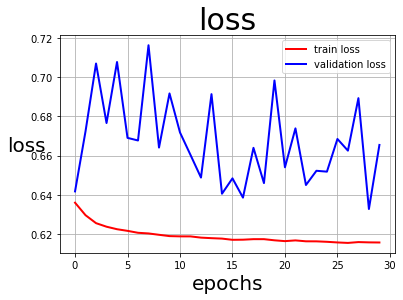

In [13]:
makeLossGraph(history)

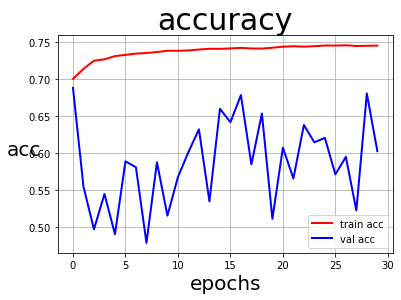

In [14]:
makeAccGraph(history)

## fine tuning
training the model with a very slow learning rate

In [15]:
base_model.trainable=True
model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

history2=model.fit(train, epochs=25,validation_data=validation)

Epoch 1/25
2048/2048 [==============================] - 158s 77ms/step - loss: 0.6067 - binary_accuracy: 0.7589 - val_loss: 0.6065 - val_binary_accuracy: 0.7477
Epoch 2/25
2048/2048 [==============================] - 157s 76ms/step - loss: 0.5827 - binary_accuracy: 0.8179 - val_loss: 0.5960 - val_binary_accuracy: 0.7814
Epoch 3/25
2048/2048 [==============================] - 157s 76ms/step - loss: 0.5746 - binary_accuracy: 0.8379 - val_loss: 0.5973 - val_binary_accuracy: 0.7676
Epoch 4/25
2048/2048 [==============================] - 156s 76ms/step - loss: 0.5698 - binary_accuracy: 0.8492 - val_loss: 0.5953 - val_binary_accuracy: 0.7722
Epoch 5/25
2048/2048 [==============================] - 156s 76ms/step - loss: 0.5670 - binary_accuracy: 0.8558 - val_loss: 0.5946 - val_binary_accuracy: 0.7719
Epoch 6/25
2048/2048 [==============================] - 156s 76ms/step - loss: 0.5642 - binary_accuracy: 0.8625 - val_loss: 0.5886 - val_binary_accuracy: 0.7921
Epoch 7/25
2048/2048 [============

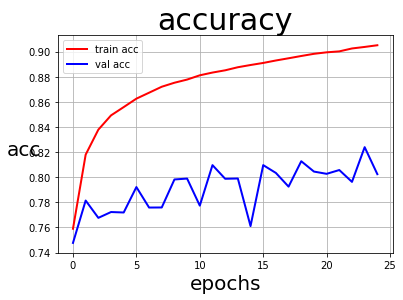

In [16]:
makeAccGraph(history2)

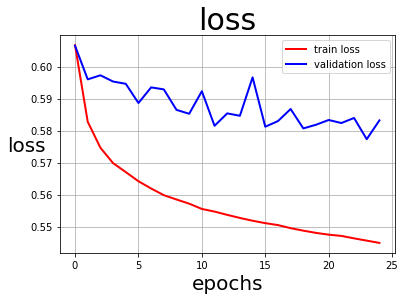

In [17]:
makeLossGraph(history2)

## testing model

In [18]:
 scores = model.evaluate(test, verbose=1) 
 print("Accuracy: ", scores[1])

256/256 [==============================] - 25s 96ms/step - loss: 0.5991 - binary_accuracy: 0.7590
Accuracy:  0.759002685546875


## saving the whole model

In [20]:
 model.save('/input', save_format='tf')

## classify images by feature vector

In [62]:
new_model=keras.Model(inputs=model.layers[0].input,outputs=model.layers[-4].output)

In [66]:
new_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         multiple                  0         
_________________________________________________________________
sequential (Sequential)      (None, 96, 96, 3)         0         
_________________________________________________________________
center_crop (CenterCrop)     (128, 48, 48, 3)          0         
_________________________________________________________________
rescaling (Rescaling)        (128, 48, 48, 3)          0         
_________________________________________________________________
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (128, 8192)               0         
_________________________________________________________________
dense (Dense)                (128, 256)              

In [67]:
preds=new_model.predict(test)

In [68]:
preds1=(np.argsort(preds[:,0]))
print (preds1)
print (preds1[10:16])
print (preds1[150:156])

[16827  5444 27706 ... 14466 22934 26580]
[ 5432 21962 21954 27703 11637 27725]
[11508 11464 27498  5638  5637  5636]


## i added image plotting in the poster because i can't get values by index when using tf.datasets, so the plotting is by the above indexes and showen in the poster.